### With help from the great Enrique

In [1]:
import glob
import os
import numpy as np
from skimage import io, transform, exposure, restoration, filters
import matplotlib.pyplot as plt
import tqdm
import panel as pn
pn.extension()

In [2]:
# I saved the four test videos in data_dir 
home_dir = os.path.expanduser('~')
data_dir = os.path.join('data')
file_list = sorted(glob.glob(data_dir + '/*'))

## Data loader

In [66]:
# idx indexes the list of videos
idx = 0
ims = io.imread(file_list[idx])
output_shape = (512,512)

In [67]:
# Most skimage functions can only take one image at a time
# We need to implement loops several times because we have videos
def apply_function_to_ims(ims, function, new_shape = None, **kwargs):
    if not new_shape:
        new_shape = ims.shape
    output_ims = np.zeros(new_shape).astype('float32')
    for i, _ in enumerate(tqdm.tqdm(ims)): # loop over images
        output_ims[i,:,:]  = function(ims[i,:,:], **kwargs)
    return output_ims

# skimage thresholding functions only give you the scalar value of the threshold
# we need to create the binary masks using the threshold
def thresholding(im, thresholding_function = None):
    return (im > thresholding_function(im)).astype('float32')

## Segmentation

In [68]:
# resize images to make computation faster
X_scaled = apply_function_to_ims(
    ims[:, 0, :,:], 
    transform.resize, 
    new_shape = (ims.shape[0], *output_shape), 
    output_shape = output_shape,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.61it/s]


In [113]:
# Apply CLAHE to improve contrast in the images (https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE)
# Finding a good value for clip_limit depends on your images and what your are trying to segment.
X_clahe = apply_function_to_ims(X_scaled,  exposure.equalize_adapthist,  clip_limit=0.01)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 76.17it/s]


In [114]:
# Denoising the images helps get better thresholding results
X_denoised = apply_function_to_ims(X_clahe, restoration.denoise_bilateral)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.85it/s]


In [115]:
# Apply threshold and create binary masks
# You can change the type of thresholding method used
# Depending on your video, some work better, so it is good to try some of them
# I highly recommend otsu and triangle
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html
X_thresh = apply_function_to_ims(X_denoised, thresholding, thresholding_function = filters.threshold_triangle)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 568.40it/s]


In [116]:
# We will use the binarized illumination region image to set to 0 all the pixels in our
# aster video that are outside of illumination region.
illumination_mask = transform.resize(ims[0,1,:,:], output_shape)
# I found this threshold (.00175) by looking at histogram of the illumination region image.
illumination_mask = (illumination_mask > 0.0016).astype('float32')
unique, counts = np.unique(illumination_mask, return_counts=True)
dict(zip(unique, counts))
X_thresh = X_thresh * illumination_mask
#print(illumination_mask)
#X_thresh

Column
    [0] Column
        [0] IntSlider(end=299, name='i')
    [1] Row
        [0] Matplotlib(Figure, height=288, name='interactive00321', width=576)
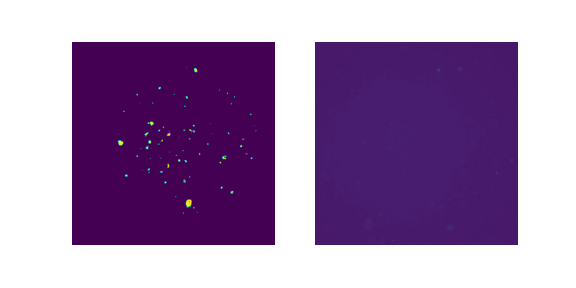

In [117]:
# Display results
def display_images(i = 0):
    f = plt.figure(figsize= (8,4))
    plt.subplot(1,2,1)
    plt.imshow(X_thresh[i,:,:])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(X_scaled[i,:,:], vmin = .0, vmax = .4)
    plt.axis('off')
    plt.close()
    return f
pn.interact(display_images, i = (0, ims.shape[0]-1))